## Neighborhood/Global Distances

In [1]:
import sys
sys.path.append('../../')
from fcc_utils import *
%matplotlib inline

In [15]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
# read in Macosko retina data
retina = sc.read_text('../../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t')
# read in Herring colon data
colon = sc.read_text('../../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', delimiter='\t', first_column_names=True)

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [4]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [5]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 

In [6]:
# get useful metrics of counts data
colon.var['mito'] = colon.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon.layers['raw_counts'] = colon.X # save raw counts in layer
sc.pp.normalize_total(colon, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

Add `Phenograph` clustering information to each `anndata` object

In [7]:
retina_clu = pd.read_csv('pymethods_out/retina_clu.csv', header=None)
retina.obs['cluster'] = retina_clu[0].values

In [8]:
colon_clu = pd.read_csv('pymethods_out/colon_clu.csv', header=None)
colon.obs['cluster'] = colon_clu[0].values

In [9]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'EMD':{'Bipolar - Rods':{}, 'Bipolar - Amacrine':{}, 'Rods - Amacrine':{}}, 'R':{'Bipolar - Rods':{}, 'Bipolar - Amacrine':{}, 'Rods - Amacrine':{}}}, 
                        'Colon':{'EMD':{'Immature - Mature':{}, 'Immature - Developing':{}, 'Developing - Mature':{}},'R':{'Immature - Mature':{}, 'Immature - Developing':{}, 'Developing - Mature':{}}}}

---

In [14]:
retina.obs.cluster.value_counts()

0.0    309
1.0    281
2.0    258
3.0    130
4.0     94
5.0     89
6.0     77
7.0     49
8.0     39
Name: cluster, dtype: int64

In [10]:
retina.X = retina.layers['arcsinh_norm']
sc.tl.pca(retina, use_highly_variable=False, n_comps=2)

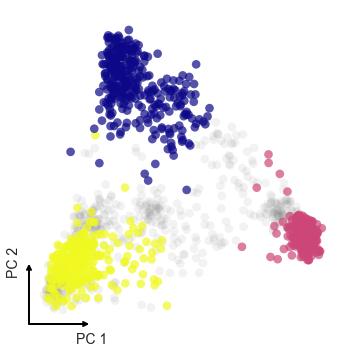

In [11]:
plot_IDs(retina, 'X_pca', 'cluster', IDs=[0,1,2], dim_name='PC') # bipolar cells, rods, and amacrine cells

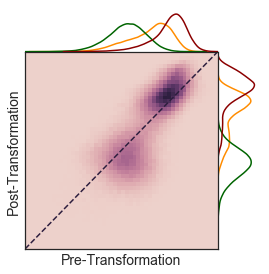

In [17]:
EMD, corr_stats = cluster_arrangement_sc(adata=retina, pre=retina.X, post=retina.obsm['X_pca'], obs_col='cluster', IDs=[0,1,2], ID_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

#plt.savefig(fname='../images/retina_neighborhood_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['PCA (2)'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['PCA (2)'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['PCA (2)'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['PCA (2)'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['PCA (2)'], final_distance_stats['Retina']['R']['Rods - Amacrine']['PCA (2)'] = corr_stats

In [8]:
retina_PCA10 = fcc_PCA(matrix=retina.arcsinh_norm(), barcodes=retina.barcodes, n_components=10)

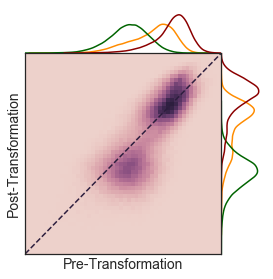

In [9]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_PCA10, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['PCA (10)'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['PCA (10)'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['PCA (10)'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['PCA (10)'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['PCA (10)'], final_distance_stats['Retina']['R']['Rods - Amacrine']['PCA (10)'] = corr_stats

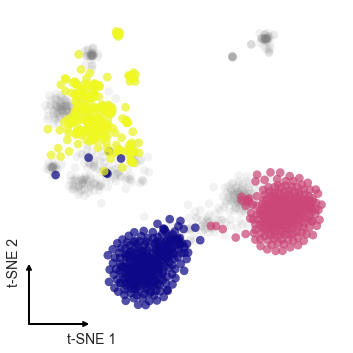

In [10]:
retina_tSNE = DR.from_file('pymethods_out/retina_tSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_tSNE.plot_barcodes(ranks=['0','1','2']) 

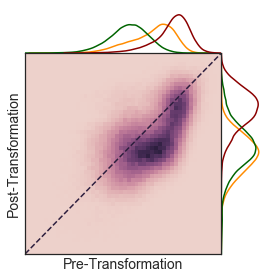

In [11]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_tSNE, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['t-SNE'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['t-SNE'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['t-SNE'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['t-SNE'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['t-SNE'], final_distance_stats['Retina']['R']['Rods - Amacrine']['t-SNE'] = corr_stats

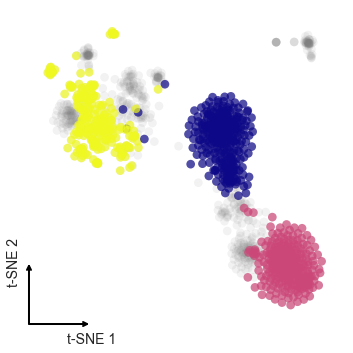

In [12]:
retina_FItSNE = DR.from_file('pymethods_out/retina_FItSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_FItSNE.plot_barcodes(ranks=['0','1','2']) 

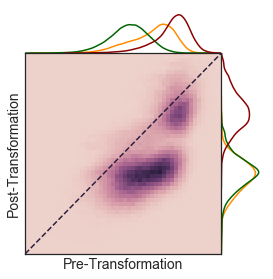

In [16]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_FItSNE, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['FIt-SNE'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['FIt-SNE'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['FIt-SNE'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['FIt-SNE'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['FIt-SNE'], final_distance_stats['Retina']['R']['Rods - Amacrine']['FIt-SNE'] = corr_stats

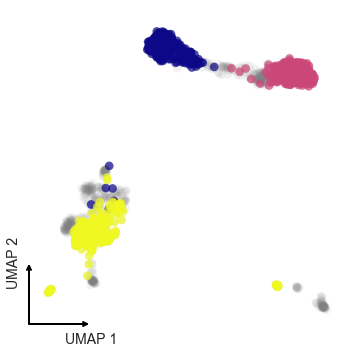

In [17]:
retina_UMAP = DR.from_file('pymethods_out/retina_UMAP.csv', name='UMAP', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_UMAP.plot_barcodes(ranks=['0','1','2']) 

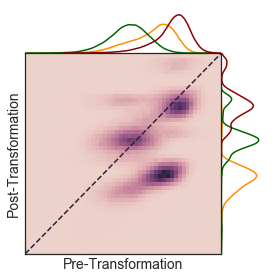

In [18]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_UMAP, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['UMAP'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['UMAP'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['UMAP'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['UMAP'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['UMAP'], final_distance_stats['Retina']['R']['Rods - Amacrine']['UMAP'] = corr_stats

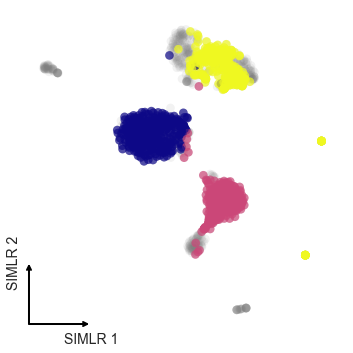

In [19]:
retina_SIMLR = DR.from_file('Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_SIMLR.plot_barcodes(ranks=['0','1','2'])

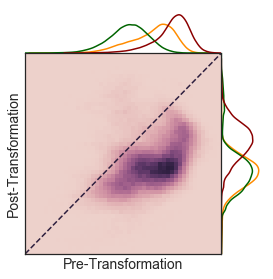

In [20]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_SIMLR, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['SIMLR'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['SIMLR'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['SIMLR'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['SIMLR'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['SIMLR'], final_distance_stats['Retina']['R']['Rods - Amacrine']['SIMLR'] = corr_stats

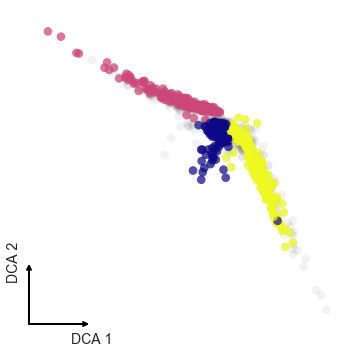

In [21]:
retina_DCA = DR.from_file('pymethods_out/retina_DCA.csv', name='DCA', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_DCA.plot_barcodes(ranks=['0','1','2']) # rods & cones

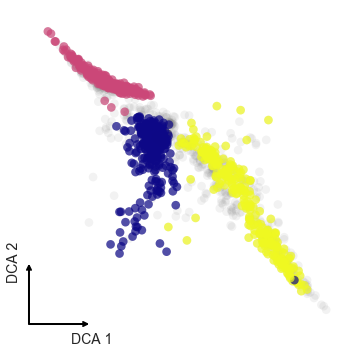

In [22]:
retina_DCA = DR(latent=retina_DCA.arcsinh_norm(norm=None, scale=1), name='DCA', barcodes=retina_DCA.barcodes)
retina_DCA.plot_barcodes(ranks=['0','1','2']) # rods & cones

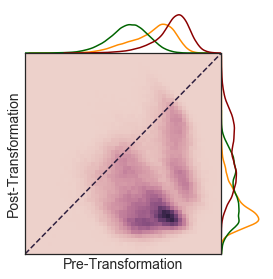

In [23]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_DCA, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['DCA'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['DCA'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['DCA'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['DCA'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['DCA'], final_distance_stats['Retina']['R']['Rods - Amacrine']['DCA'] = corr_stats

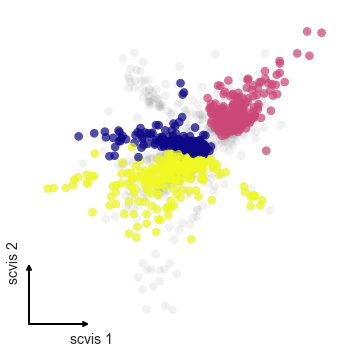

In [24]:
retina_scvis = DR.from_file('scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', name='scvis', labels=[0,0], barcodefile='pymethods_out/retina_clu.csv')
retina_scvis.plot_barcodes(ranks=['0','1','2']) # rods & cones

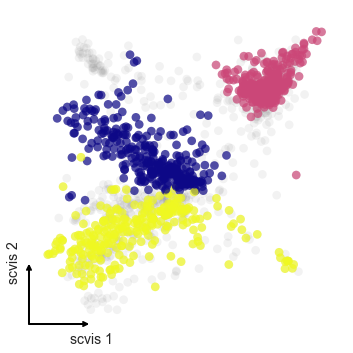

In [25]:
retina_scvis = DR(latent=retina_scvis.arcsinh_norm(norm=None, scale=1), name='scvis', barcodes=retina_scvis.barcodes)
retina_scvis.plot_barcodes(ranks=['0','1','2']) # rods & cones

In [26]:
retina_scvis.plot_barcodes(ranks=['0','1','2'], figsize=(4,4), save_to='../images/retina_neighborhood_scvis.png') # rods & cones

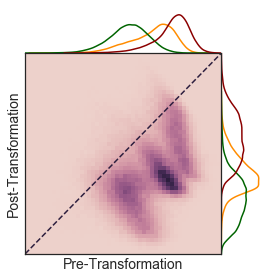

In [27]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_scvis, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['scvis'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['scvis'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['scvis'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['scvis'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['scvis'], final_distance_stats['Retina']['R']['Rods - Amacrine']['scvis'] = corr_stats

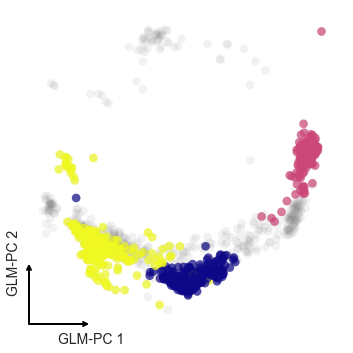

In [28]:
retina_GLMPCA = DR.from_file('Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_GLMPCA.plot_barcodes(ranks=['0','1','2']) 

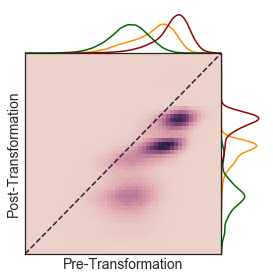

In [29]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_GLMPCA, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['GLM-PCA'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['GLM-PCA'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['GLM-PCA'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['GLM-PCA'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['GLM-PCA'], final_distance_stats['Retina']['R']['Rods - Amacrine']['GLM-PCA'] = corr_stats

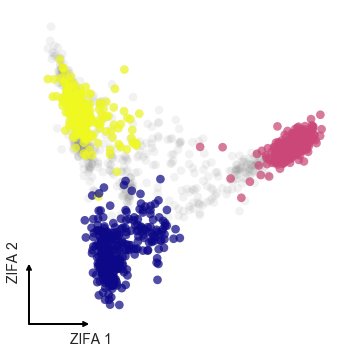

In [30]:
retina_ZIFA = DR.from_file('pymethods_out/retina_ZIFA.csv', name='ZIFA', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_ZIFA.plot_barcodes(ranks=['0','1','2']) # rods & cones

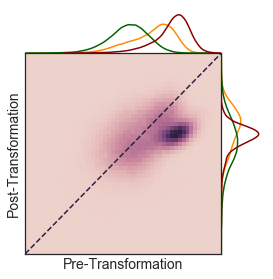

In [31]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_ZIFA, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['ZIFA'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['ZIFA'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['ZIFA'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['ZIFA'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['ZIFA'], final_distance_stats['Retina']['R']['Rods - Amacrine']['ZIFA'] = corr_stats

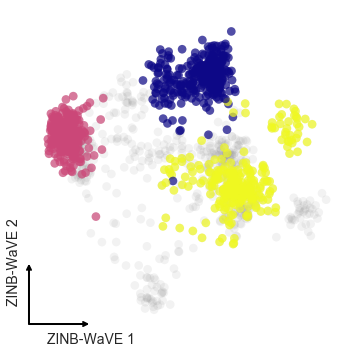

In [32]:
retina_ZINBWAVE = DR.from_file('Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_ZINBWAVE.plot_barcodes(ranks=['0','1','2']) 

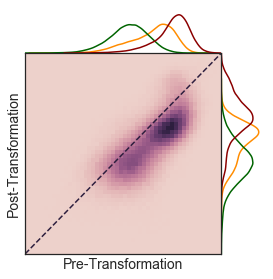

In [33]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_ZINBWAVE, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['ZINB-WaVE'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['ZINB-WaVE'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['ZINB-WaVE'], final_distance_stats['Retina']['R']['Rods - Amacrine']['ZINB-WaVE'] = corr_stats

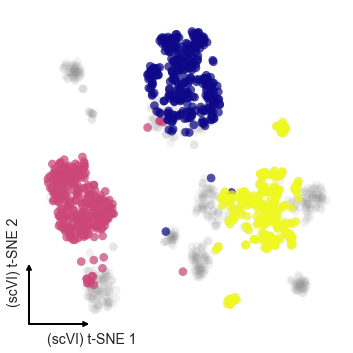

In [34]:
retina_scVI = DR.from_file('pymethods_out/retina_scVI.csv', name='scVI', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_scVI_tSNE = DR.from_file('pymethods_out/retina_scVI_tSNE.csv', name='(scVI) t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_scVI_tSNE.plot_barcodes(ranks=['0','1','2'])

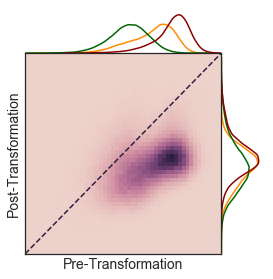

In [35]:
EMD, corr_stats = cluster_arrangement(pre_obj=retina, post_obj=retina_scVI, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['EMD']['Bipolar - Rods']['scVI'], final_distance_stats['Retina']['EMD']['Bipolar - Amacrine']['scVI'], final_distance_stats['Retina']['EMD']['Rods - Amacrine']['scVI'] = EMD
final_distance_stats['Retina']['R']['Bipolar - Rods']['scVI'], final_distance_stats['Retina']['R']['Bipolar - Amacrine']['scVI'], final_distance_stats['Retina']['R']['Rods - Amacrine']['scVI'] = corr_stats

---
Now Colon Dataset

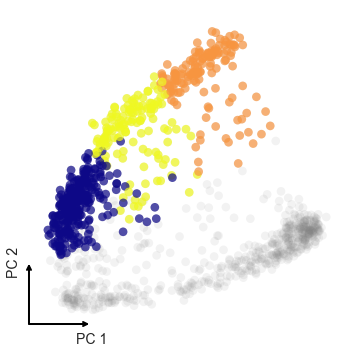

In [8]:
colon_PCA2 = fcc_PCA(matrix=colon.arcsinh_norm(), barcodes=colon.barcodes, n_components=2)
colon_PCA2.plot_barcodes(ranks=['0','3','4']) # mature and developing goblet cells

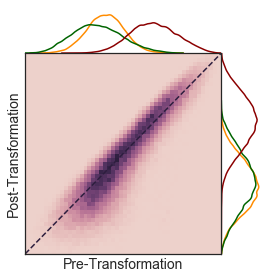

In [9]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_PCA2, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Developing']['PCA (2)'], final_distance_stats['Colon']['EMD']['Developing - Mature']['PCA (2)'], final_distance_stats['Colon']['EMD']['Immature - Mature']['PCA (2)'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['PCA (2)'], final_distance_stats['Colon']['R']['Developing - Mature']['PCA (2)'], final_distance_stats['Colon']['R']['Immature - Mature']['PCA (2)'] = corr_stats

In [10]:
colon_PCA10 = fcc_PCA(matrix=colon.arcsinh_norm(), barcodes=colon.barcodes, n_components=10)

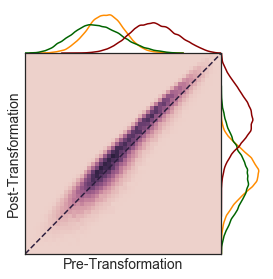

In [11]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_PCA10, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Developing']['PCA (10)'], final_distance_stats['Colon']['EMD']['Developing - Mature']['PCA (10)'], final_distance_stats['Colon']['EMD']['Immature - Mature']['PCA (10)'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['PCA (10)'], final_distance_stats['Colon']['R']['Developing - Mature']['PCA (10)'], final_distance_stats['Colon']['R']['Immature - Mature']['PCA (10)'] = corr_stats

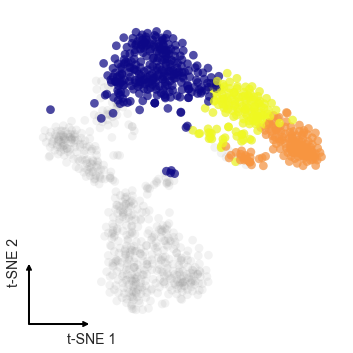

In [7]:
colon_tSNE = DR.from_file('pymethods_out/colon_tSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_tSNE.plot_barcodes(ranks=['0','3','4']) 

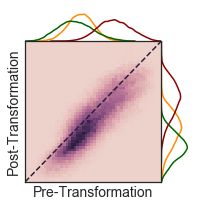

In [8]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_tSNE, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['t-SNE'], final_distance_stats['Colon']['EMD']['Immature - Developing']['t-SNE'], final_distance_stats['Colon']['EMD']['Developing - Mature']['t-SNE'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['t-SNE'], final_distance_stats['Colon']['R']['Developing - Mature']['t-SNE'], final_distance_stats['Colon']['R']['Immature - Mature']['t-SNE'] = corr_stats

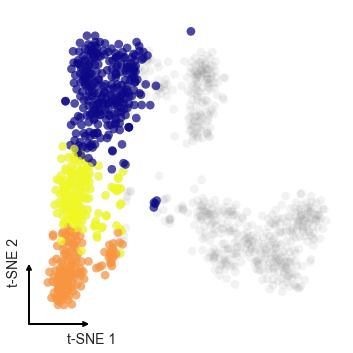

In [14]:
colon_FItSNE = DR.from_file('pymethods_out/colon_FItSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_FItSNE.plot_barcodes(ranks=['0','3','4']) 

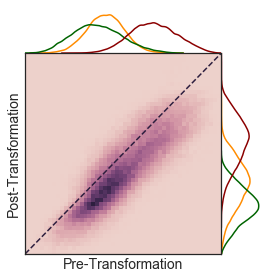

In [15]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_FItSNE, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['FIt-SNE'], final_distance_stats['Colon']['EMD']['Immature - Developing']['FIt-SNE'], final_distance_stats['Colon']['EMD']['Developing - Mature']['FIt-SNE'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['FIt-SNE'], final_distance_stats['Colon']['R']['Developing - Mature']['FIt-SNE'], final_distance_stats['Colon']['R']['Immature - Mature']['FIt-SNE'] = corr_stats

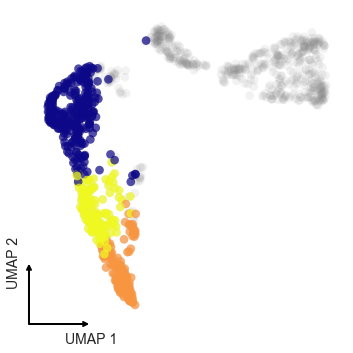

In [16]:
colon_UMAP = DR.from_file('pymethods_out/colon_UMAP.csv', name='UMAP', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_UMAP.plot_barcodes(ranks=['0','3','4']) 

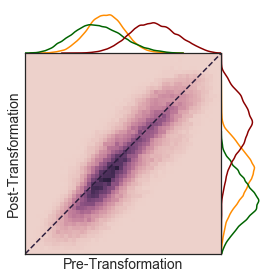

In [17]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_UMAP, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['UMAP'], final_distance_stats['Colon']['EMD']['Immature - Developing']['UMAP'], final_distance_stats['Colon']['EMD']['Developing - Mature']['UMAP'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['UMAP'], final_distance_stats['Colon']['R']['Developing - Mature']['UMAP'], final_distance_stats['Colon']['R']['Immature - Mature']['UMAP'] = corr_stats

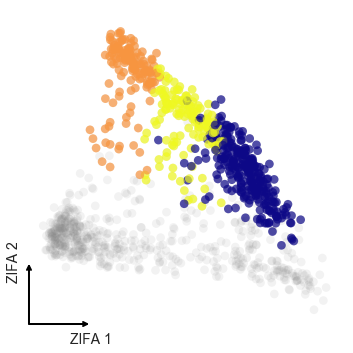

In [18]:
colon_ZIFA = DR.from_file('pymethods_out/colon_ZIFA.csv', name='ZIFA', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_ZIFA.plot_barcodes(ranks=['0','3','4'])

In [19]:
colon_ZIFA.plot_barcodes(ranks=['0','3','4'], figsize=(4,4), save_to='../images/colon_neighborhood_ZIFA.png')

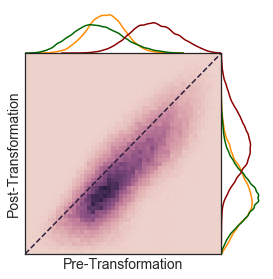

In [20]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_ZIFA, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['ZIFA'], final_distance_stats['Colon']['EMD']['Immature - Developing']['ZIFA'], final_distance_stats['Colon']['EMD']['Developing - Mature']['ZIFA'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['ZIFA'], final_distance_stats['Colon']['R']['Developing - Mature']['ZIFA'], final_distance_stats['Colon']['R']['Immature - Mature']['ZIFA'] = corr_stats

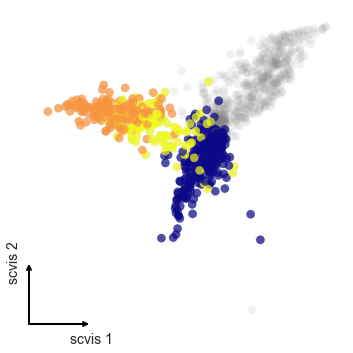

In [21]:
colon_scvis = DR.from_file('scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', name='scvis', labels=[0,0], barcodefile='pymethods_out/colon_clu.csv')
colon_scvis.plot_barcodes(ranks=['0','3','4'])

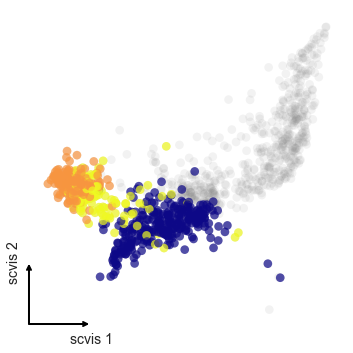

In [22]:
colon_scvis = DR(latent=colon_scvis.arcsinh_norm(norm=None, scale=1), name='scvis', barcodes=colon_scvis.barcodes)
colon_scvis.plot_barcodes(ranks=['0','3','4']) 

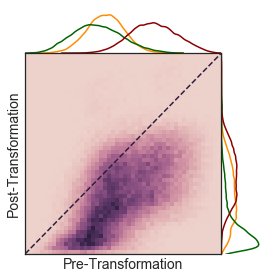

In [23]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_scvis, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['scvis'], final_distance_stats['Colon']['EMD']['Immature - Developing']['scvis'], final_distance_stats['Colon']['EMD']['Developing - Mature']['scvis'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['scvis'], final_distance_stats['Colon']['R']['Developing - Mature']['scvis'], final_distance_stats['Colon']['R']['Immature - Mature']['scvis'] = corr_stats

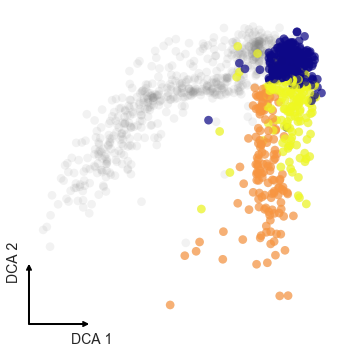

In [24]:
colon_DCA = DR.from_file('pymethods_out/colon_DCA.csv', name='DCA', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_DCA.plot_barcodes(ranks=['0','3','4'])

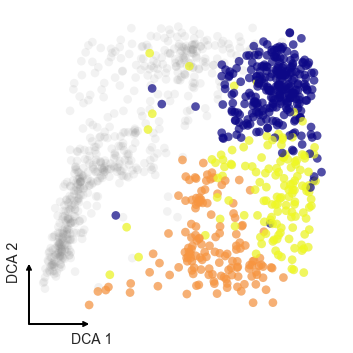

In [25]:
colon_DCA = DR(latent=colon_DCA.arcsinh_norm(norm=None, scale=1), name='DCA', barcodes=colon_DCA.barcodes)
colon_DCA.plot_barcodes(ranks=['0','3','4']) 

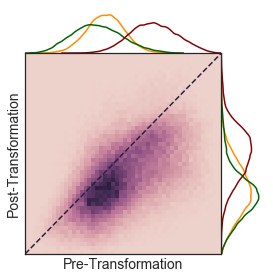

In [26]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_DCA, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['DCA'], final_distance_stats['Colon']['EMD']['Immature - Developing']['DCA'], final_distance_stats['Colon']['EMD']['Developing - Mature']['DCA'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['DCA'], final_distance_stats['Colon']['R']['Developing - Mature']['DCA'], final_distance_stats['Colon']['R']['Immature - Mature']['DCA'] = corr_stats

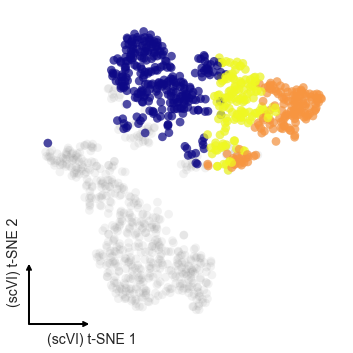

In [27]:
colon_scVI = DR.from_file('pymethods_out/colon_scVI.csv', name='scVI', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_scVI_tSNE = DR.from_file('pymethods_out/colon_scVI_tSNE.csv', name='(scVI) t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_scVI_tSNE.plot_barcodes(ranks=['0','3','4'])

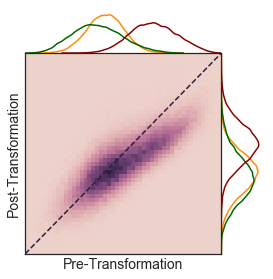

In [28]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_scVI, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['scVI'], final_distance_stats['Colon']['EMD']['Immature - Developing']['scVI'], final_distance_stats['Colon']['EMD']['Developing - Mature']['scVI'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['scVI'], final_distance_stats['Colon']['R']['Developing - Mature']['scVI'], final_distance_stats['Colon']['R']['Immature - Mature']['scVI'] = corr_stats

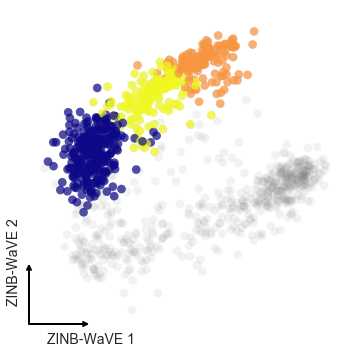

In [29]:
colon_ZINBWAVE = DR.from_file('Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_ZINBWAVE.plot_barcodes(ranks=['0','3','4']) 

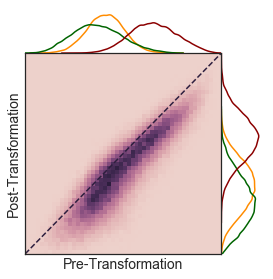

In [30]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_ZINBWAVE, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['Immature - Developing']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['Developing - Mature']['ZINB-WaVE'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['ZINB-WaVE'], final_distance_stats['Colon']['R']['Developing - Mature']['ZINB-WaVE'], final_distance_stats['Colon']['R']['Immature - Mature']['ZINB-WaVE'] = corr_stats

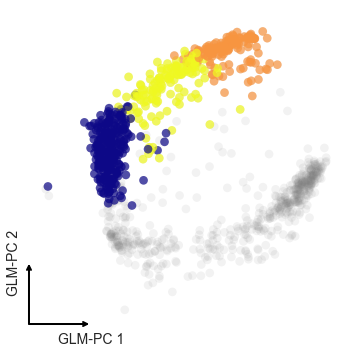

In [31]:
colon_GLMPCA = DR.from_file('Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_GLMPCA.plot_barcodes(ranks=['0','3','4']) 

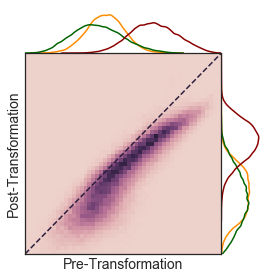

In [32]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_GLMPCA, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['GLM-PCA'], final_distance_stats['Colon']['EMD']['Immature - Developing']['GLM-PCA'], final_distance_stats['Colon']['EMD']['Developing - Mature']['GLM-PCA'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['GLM-PCA'], final_distance_stats['Colon']['R']['Developing - Mature']['GLM-PCA'], final_distance_stats['Colon']['R']['Immature - Mature']['GLM-PCA'] = corr_stats

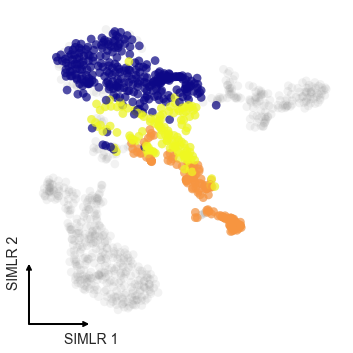

In [33]:
colon_SIMLR = DR.from_file('Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_SIMLR.plot_barcodes(ranks=['0','3','4'])

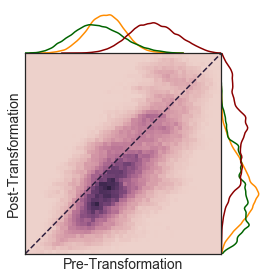

In [34]:
EMD, corr_stats = cluster_arrangement(pre_obj=colon, post_obj=colon_SIMLR, clusters=['4','0','3'], cluster_names=['Developing Goblet Cells','Immature Goblet Cells','Mature Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['EMD']['Immature - Mature']['SIMLR'], final_distance_stats['Colon']['EMD']['Immature - Developing']['SIMLR'], final_distance_stats['Colon']['EMD']['Developing - Mature']['SIMLR'] = EMD
final_distance_stats['Colon']['R']['Immature - Developing']['SIMLR'], final_distance_stats['Colon']['R']['Developing - Mature']['SIMLR'], final_distance_stats['Colon']['R']['Immature - Mature']['SIMLR'] = corr_stats

---
### Summary Metrics

In [64]:
retina_EMD = pd.DataFrame(final_distance_stats['Retina']['EMD'])
retina_EMD['Sum'] = retina_EMD.sum(axis=1)
retina_EMD = retina_EMD.sort_values(by='Sum', ascending=False)
retina_EMD = retina_EMD.drop('Sum', axis=1)
retina_EMD.to_csv('retina_neighborhood_EMD.csv')

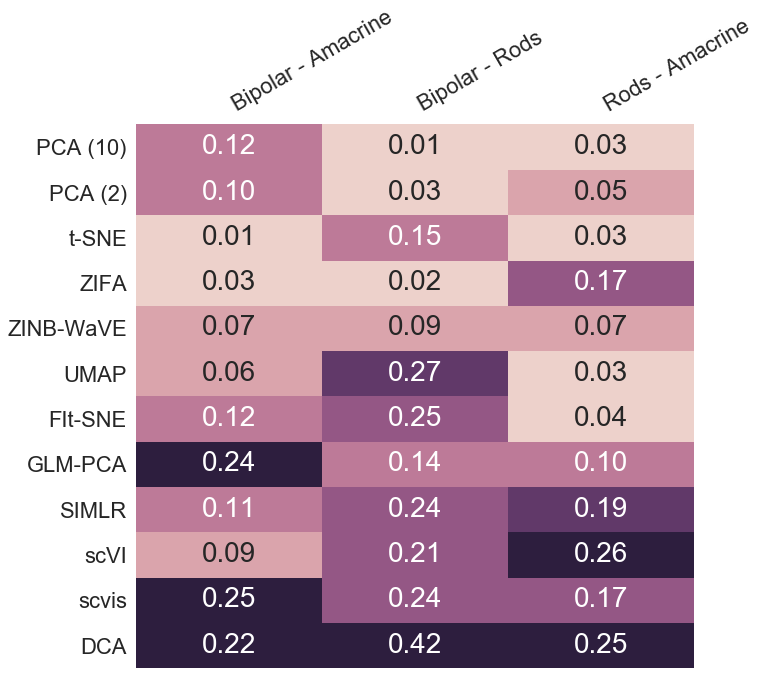

In [65]:
retina_norm=(retina_EMD-retina_EMD.mean())/retina_EMD.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_EMD, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.xticks(rotation=30, ha='left')
ax.tick_params(top=False)
plt.savefig(fname='../images/retina_neighborhood_EMD.png', transparent=True, bbox_inches='tight')

In [74]:
retina_R = pd.DataFrame(final_distance_stats['Retina']['R'])
retina_R['Sum'] = retina_R.sum(axis=1)
retina_R = retina_R.sort_values(by='Sum', ascending=True)
retina_R = retina_R.drop('Sum', axis=1)
retina_R.to_csv('retina_neighborhood_corr.csv')

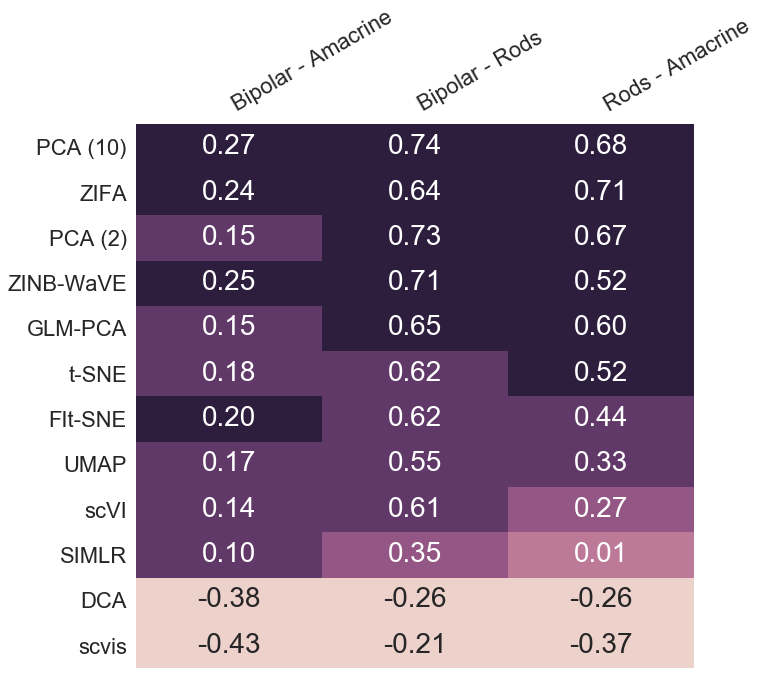

In [75]:
retina_norm=(retina_R-retina_R.mean())/retina_R.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_R, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.xticks(rotation=30, ha='left')
ax.tick_params(top=False)
plt.savefig(fname='../images/retina_neighborhood_corr.png', transparent=True, bbox_inches='tight')

---

In [35]:
colon_EMD = pd.DataFrame(final_distance_stats['Colon']['EMD'])
colon_EMD['Sum'] = colon_EMD.sum(axis=1)
colon_EMD = colon_EMD.sort_values(by='Sum', ascending=False)
colon_EMD = colon_EMD.drop('Sum', axis=1)
colon_EMD.to_csv('colon_neighborhood_EMD.csv')

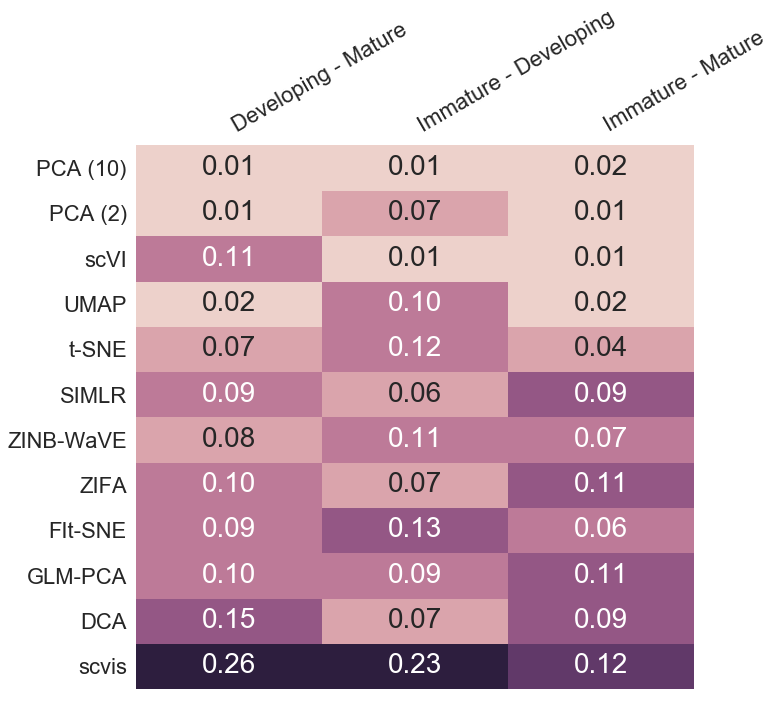

In [36]:
colon_norm=(colon_EMD-colon_EMD.mean())/colon_EMD.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_EMD, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.xticks(rotation=30, ha='left')
ax.tick_params(top=False)
plt.savefig(fname='../images/colon_neighborhood_EMD.png', transparent=True, bbox_inches='tight')

In [37]:
colon_R = pd.DataFrame(final_distance_stats['Colon']['R'])
colon_R['Sum'] = colon_R.sum(axis=1)
colon_R = colon_R.sort_values(by='Sum', ascending=True)
colon_R = colon_R.drop('Sum', axis=1)
colon_R.to_csv('colon_neighborhood_corr.csv')

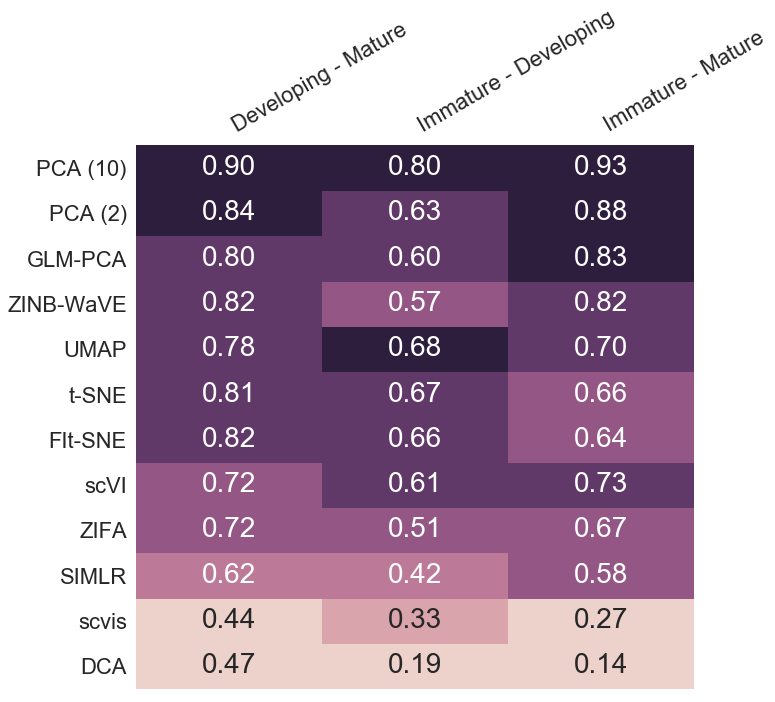

In [38]:
colon_norm=(colon_R-colon_R.mean())/colon_R.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_R, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.xticks(rotation=30, ha='left')
ax.tick_params(top=False)
plt.savefig(fname='../images/colon_neighborhood_corr.png', transparent=True, bbox_inches='tight')